# Big Code Bench
Much more manageable size - 20MB on disk.

Compared to this benchmark:
* __Live Code Bench__ has 2 main issues: dataset size and test cases. It takes ~10GB on disk, contains problems from LeetCode, AtCoder, and CodeForces between May 2023 and May 2024, has an exruciating number of test cases - some don't fit into the Jupyter Notebook cell causing output errors. Private test cases are scrambled and look unusable.
* __Taco__ has the same 2 main issues: dataset size and test cases. It takes 5GB on disk, there are no test cases per say, but only inputs and expected outputs. Since they come from different sources, it may take time to parse them properly and write assert statements or test cases for them.

In [1]:
import datasets
import json
import ast
import traceback
import re
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## EDA

In [2]:
big = datasets.load_dataset("bigcode/bigcodebench")

In [148]:
# saved to disk
from datasets import load_from_disk
big.save_to_disk('datasets/big-code-bench')

Saving the dataset (0/1 shards):   0%|          | 0/1140 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1140 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1140 [00:00<?, ? examples/s]

In [3]:
big

DatasetDict({
    v0.1.0_hf: Dataset({
        features: ['task_id', 'complete_prompt', 'instruct_prompt', 'canonical_solution', 'code_prompt', 'test', 'entry_point', 'doc_struct', 'libs'],
        num_rows: 1140
    })
    v0.1.1: Dataset({
        features: ['task_id', 'complete_prompt', 'instruct_prompt', 'canonical_solution', 'code_prompt', 'test', 'entry_point', 'doc_struct', 'libs'],
        num_rows: 1140
    })
    v0.1.2: Dataset({
        features: ['task_id', 'complete_prompt', 'instruct_prompt', 'canonical_solution', 'code_prompt', 'test', 'entry_point', 'doc_struct', 'libs'],
        num_rows: 1140
    })
    v0.1.3: Dataset({
        features: ['task_id', 'complete_prompt', 'instruct_prompt', 'canonical_solution', 'code_prompt', 'test', 'entry_point', 'doc_struct', 'libs'],
        num_rows: 1140
    })
})

In [4]:
min_value, max_value = 0, 25
for i, sample in enumerate(big['v0.1.3']):
    if i < min_value:
        continue
    if i > max_value:
        break
    print(f'Sample {i}')
    for k,v in sample.items():
        if k == 'doc_struct':
            v = json.loads(v)
            print(type(k), type(v))
            for k2, v2 in v.items():
                print(f'{k2}:\n{v2}')
        else:
            print(type(k), type(v))
            print(f'{k}:\n{v}')
        print('\n', '-'*50, '\n', sep='')
    print('\n', '='*100, '\n', sep='')

Sample 0
<class 'str'> <class 'str'>
task_id:
BigCodeBench/0

--------------------------------------------------

<class 'str'> <class 'str'>
complete_prompt:
import itertools
from random import shuffle

def task_func(numbers=list(range(1, 3))):
    """
    Calculates the average of the sums of absolute differences between each pair of consecutive numbers 
    for all permutations of a given list. Each permutation is shuffled before calculating the differences.

    Args:
    - numbers (list): A list of numbers. Default is numbers from 1 to 10.
    
    Returns:
    float: The average of the sums of absolute differences for each shuffled permutation of the list.

    Requirements:
    - itertools
    - random.shuffle

    Example:
    >>> result = task_func([1, 2, 3])
    >>> isinstance(result, float)
    True
    """


--------------------------------------------------

<class 'str'> <class 'str'>
instruct_prompt:
Calculates the average of the sums of absolute differences between each

## Test one data sample

In [21]:
#%tb
import collections
import random
import string

def task_func(length=100):
    """
    Generate a random string of the specified length composed of uppercase and lowercase letters, 
    and then count the occurrence of each character in this string.

    Parameters:
    length (int, optional): The number of characters in the generated string. Default is 100.

    Returns:
    dict: A dictionary where each key is a character from the generated string and the value 
            is the count of how many times that character appears in the string.

    Requirements:
    - collections
    - random
    - string

    Raises:
    ValueError if the length is a negative number

    Example:
    >>> import random
    >>> random.seed(42)  # Ensures reproducibility for demonstration
    >>> task_func(10)
    {'h': 1, 'B': 2, 'O': 1, 'L': 1, 'm': 1, 'j': 1, 'u': 1, 'E': 1, 'V': 1}
    """

    if length < 0:
        raise ValueError
    random_string = ''.join(random.choices(string.ascii_uppercase + string.ascii_lowercase, k=length))
    char_counts = collections.Counter(random_string)
    return dict(char_counts)


import unittest
import string
class TestCases(unittest.TestCase):
    def setUp(self):
        # Prepare valid characters and set a random seed for reproducibility
        self.valid_chars = string.ascii_uppercase + string.ascii_lowercase
        random.seed(42)  # Ensuring reproducibility for tests
    def test_generated_string_properties(self):
        # Consolidated test for different lengths to check structure and correctness
        test_lengths = [10, 50, 100, 150, 5]
        for length in test_lengths:
            with self.subTest(length=length):
                result = task_func(length)
                self.assertTrue(len(result) <= length, "Length of result should be <= requested string length")
                self.assertEqual(sum(result.values()), length, f"Total counts should sum to {length}")
                self.assertTrue(all(char in self.valid_chars for char in result), "All characters should be valid letters")
    def test_zero_length(self):
        # Test edge case where length is zero
        result = task_func(0)
        self.assertEqual(len(result), 0, "Result should be empty for zero length")
        self.assertEqual(sum(result.values()), 0, "Sum of counts should be zero for zero length")
    def test_negative_length(self):
        # Test handling of negative length input
        with self.assertRaises(ValueError, msg="Negative length should raise an error"):
            task_func(-1)


if __name__ == '__main__':
     unittest.main(argv=['first-arg-is-ignored'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.001s

OK


## Test the entire dataset
This is a test of the approach that I will use in the execution.py file for evaluating the code generated based on the Big Code Bench challenges

In [3]:
min_value, max_value = 0, 2000
result = []
for i, sample in enumerate(big['v0.1.3']):
    if i < min_value:
        continue
    if i > max_value:
        break
    check_program = (
        sample['complete_prompt'] + '\n' + sample['canonical_solution']    # full function
        + '\n\n'             
        + sample['test']                                                   # TestCases class
        + '\n\n'
        + "if __name__ == '__main__':\n"
        + "    unittest.main()\n"
    )    
    try:
        exec_globals = {}
        exec(check_program, exec_globals)
        result.append("passed")
    except Exception as e:
        result.append(f"failed (exception): {e}. Traceback: {traceback.format_exc()}")
    except BaseException as e:
        result.append(f"failed (base exception): {e}. Traceback: {traceback.format_exc()}")

[nltk_data] Downloading package punkt to /Users/andrew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/andrew/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /Users/andrew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[

In [4]:
# how many passed and didn't pass
print(len(result))
print(len(set(result)))
print(len([i for i in result if i=='passed']))

1140
73
1040


In [5]:
# what are the main errors
missing_modules_errors = sorted(set([i for i in result if i != 'passed']))
missing_modules_errors

['failed (exception): No module named \'Levenshtein\'. Traceback: Traceback (most recent call last):\n  File "/var/folders/vb/p2r9brhx2335cwnww04p9w180000gn/T/ipykernel_57795/19364550.py", line 18, in <module>\n    exec(check_program, exec_globals)\n  File "<string>", line 4, in <module>\nModuleNotFoundError: No module named \'Levenshtein\'\n',
 'failed (exception): No module named \'blake3\'. Traceback: Traceback (most recent call last):\n  File "/var/folders/vb/p2r9brhx2335cwnww04p9w180000gn/T/ipykernel_57795/19364550.py", line 18, in <module>\n    exec(check_program, exec_globals)\n  File "<string>", line 3, in <module>\nModuleNotFoundError: No module named \'blake3\'\n',
 'failed (exception): No module named \'cv2\'. Traceback: Traceback (most recent call last):\n  File "/var/folders/vb/p2r9brhx2335cwnww04p9w180000gn/T/ipykernel_57795/19364550.py", line 18, in <module>\n    exec(check_program, exec_globals)\n  File "<string>", line 1, in <module>\nModuleNotFoundError: No module nam

In [11]:
# indices of errors
error_indices = [idx for idx, item in enumerate(result) if item != 'passed']
print('Total errors:', len(error_indices))
print('Error indices:', error_indices)

Total errors: 100
Error indices: [34, 59, 76, 77, 78, 79, 81, 82, 83, 166, 181, 183, 185, 186, 187, 188, 214, 227, 236, 238, 242, 270, 272, 282, 284, 285, 286, 287, 289, 292, 295, 300, 313, 315, 337, 340, 347, 372, 377, 378, 383, 392, 395, 401, 403, 404, 408, 413, 417, 418, 419, 423, 424, 425, 426, 431, 490, 494, 498, 499, 500, 501, 504, 546, 583, 584, 585, 586, 587, 590, 719, 764, 778, 786, 788, 790, 792, 797, 799, 805, 808, 815, 821, 826, 829, 830, 831, 839, 842, 844, 845, 848, 865, 866, 873, 878, 884, 933, 964, 1019]


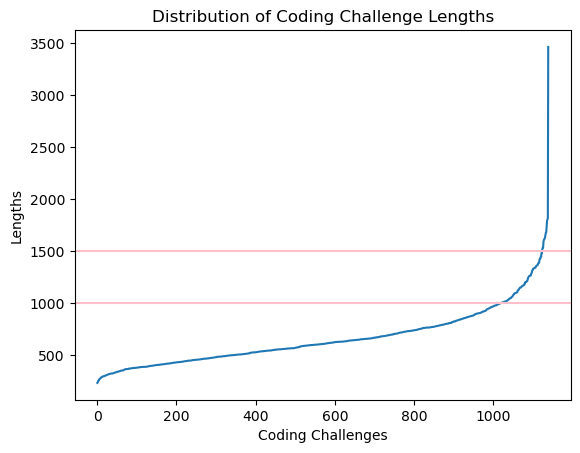

In [25]:
# length of coding problem description
lengths = sorted([len(i['instruct_prompt']) for i in big['v0.1.3']])
plt.plot(lengths)
plt.axhline(y=1500, color='pink', linestyle='-')
plt.axhline(y=1000, color='pink', linestyle='-')
plt.title('Distribution of Coding Challenge Lengths')
plt.ylabel('Lengths')
plt.xlabel('Coding Challenges')
plt.show()

__Strategy to select a subset of Big Code Bench challanges for my purposes:__
* Exclude data points that generate errors.
* I will not exclude data points whose description is "too long" just to keep my distribution as similar as possible the Big Code Bench leaderboard.

## Select a dataset subset

In [31]:
# exclude indices with errors
all_indices = list(range(len(big['v0.1.3'])))
all_indices = [i for i in all_indices if i not in error_indices]
len(all_indices)

1040

In [35]:
# take 500 random elements
seed = 47
n    = 500
random.seed(seed)
select_indices = random.sample(all_indices, n)
len(select_indices)

500

In [37]:
# re-test to see if there are any error remaining
result = []
for i, sample in enumerate(big['v0.1.3']):
    
    # skip non-selected challenges
    if i not in select_indices:
        continue
        
    check_program = (
        sample['complete_prompt'] + '\n' + sample['canonical_solution']    # full function
        + '\n\n'             
        + sample['test']                                                   # TestCases class
        + '\n\n'
        + "if __name__ == '__main__':\n"
        + "    unittest.main()\n"
    )    
    try:
        exec_globals = {}
        exec(check_program, exec_globals)
        result.append("passed")
    except Exception as e:
        result.append(f"failed (exception): {e}. Traceback: {traceback.format_exc()}")
    except BaseException as e:
        result.append(f"failed (base exception): {e}. Traceback: {traceback.format_exc()}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# how many passed and didn't pass
print(len(result))
print(len(set(result)))
print(len([i for i in result if i=='passed']))

500
1
500


__All tests passed__

## Save a dataset subset for code generation evaluation

In [42]:
# build subset
problems_bigcode = []

for i, sample in enumerate(big['v0.1.3']):
    
    # skip non-selected challenges
    if i not in select_indices:
        continue

    test_code = (
        '\n\n'             
        + sample['test']                                                   # TestCases class
        + '\n\n'
        + "if __name__ == '__main__':\n"
        + "    unittest.main()\n"
    )   

    problem = {
        'task_id': sample['task_id'],
        'test': test_code,
        'prompt':  sample['complete_prompt'],
        'canonical_solution': sample['canonical_solution'],
        'entry_point': sample['entry_point'],
    }

    problems_bigcode.append(problem)
len(problems_bigcode)

500

In [43]:
# verify subset
min_value, max_value = 0, 5
for i, sample in enumerate(problems_bigcode):
    if i < min_value:
        continue
    if i > max_value:
        break
    print(f'Sample {i}')
    for k,v in sample.items():
        print(type(k), type(v))
        print(f'{k}:\n{v}')
        print('\n', '-'*50, '\n', sep='')
    print('\n', '='*100, '\n', sep='')

Sample 0
<class 'str'> <class 'str'>
task_id:
BigCodeBench/0

--------------------------------------------------

<class 'str'> <class 'str'>
test:


import unittest
from unittest.mock import patch
from random import seed, shuffle
import itertools
class TestCases(unittest.TestCase):
    def test_default_numbers(self):
        # Test with default number range (1 to 10) to check that the result is a positive float.
        result = task_func()
        self.assertIsInstance(result, float)
        self.assertGreater(result, 0)
    def test_custom_list(self):
        # Test with a custom list of small positive integers to ensure proper handling and positive result.
        result = task_func([1, 2, 3])
        self.assertIsInstance(result, float)
        self.assertGreater(result, 0)
    def test_negative_numbers(self):
        # Test with negative numbers to verify the function handles and returns a positive result.
        result = task_func([-3, -2, -1])
        self.assertIsInstance(res

In [50]:
from typing import Iterable, Dict
import gzip
import json
import os

def write_jsonl(filename: str, data: Iterable[Dict], append: bool = False):
    """
    Writes an iterable of dictionaries to jsonl
    """
    if append:
        mode = 'ab'
    else:
        mode = 'wb'
    filename = os.path.expanduser(filename)
    if filename.endswith(".gz"):
        with open(filename, mode) as fp:
            with gzip.GzipFile(fileobj=fp, mode='wb') as gzfp:
                for x in data:
                    gzfp.write((json.dumps(x) + "\n").encode('utf-8'))
    else:
        with open(filename, mode) as fp:
            for x in data:
                fp.write((json.dumps(x) + "\n").encode('utf-8'))

In [52]:
# save subset
file = 'data/Big_Code_Bench_Test.jsonl.gz'
write_jsonl(file, problems_bigcode)

## Test new package

In [2]:
from human_eval.data import read_problems, HUMAN_EVAL, MBPP_TEST, BIGCODE_TEST

In [3]:
problems = read_problems(BIGCODE_TEST)

In [4]:
problems

{'BigCodeBench/0': {'task_id': 'BigCodeBench/0',
  'test': "\n\nimport unittest\nfrom unittest.mock import patch\nfrom random import seed, shuffle\nimport itertools\nclass TestCases(unittest.TestCase):\n    def test_default_numbers(self):\n        # Test with default number range (1 to 10) to check that the result is a positive float.\n        result = task_func()\n        self.assertIsInstance(result, float)\n        self.assertGreater(result, 0)\n    def test_custom_list(self):\n        # Test with a custom list of small positive integers to ensure proper handling and positive result.\n        result = task_func([1, 2, 3])\n        self.assertIsInstance(result, float)\n        self.assertGreater(result, 0)\n    def test_negative_numbers(self):\n        # Test with negative numbers to verify the function handles and returns a positive result.\n        result = task_func([-3, -2, -1])\n        self.assertIsInstance(result, float)\n        self.assertGreater(result, 0)\n    def test_sin

## Appendix (irrelevant)

Attempt to parse missing modules, save them into `requirements.txt` and install them - the kernel is forced to restart when I do this. This probably means that once some packages are installed, there is no error saying that they are missing, and the code execution leads to some bigger errors. Solution - we are better off when the modules are not installed => do not install `requirement.txt` and exclude these test cases from the final selection of 500 test cases.

In [11]:
# what are the main errors
missing_modules_errors = sorted(set([i for i in result if i != 'passed']))
missing_modules_errors

['failed (exception): No module named \'Levenshtein\'. Traceback: Traceback (most recent call last):\n  File "/var/folders/vb/p2r9brhx2335cwnww04p9w180000gn/T/ipykernel_46388/19364550.py", line 18, in <module>\n    exec(check_program, exec_globals)\n  File "<string>", line 4, in <module>\nModuleNotFoundError: No module named \'Levenshtein\'\n',
 'failed (exception): No module named \'blake3\'. Traceback: Traceback (most recent call last):\n  File "/var/folders/vb/p2r9brhx2335cwnww04p9w180000gn/T/ipykernel_46388/19364550.py", line 18, in <module>\n    exec(check_program, exec_globals)\n  File "<string>", line 3, in <module>\nModuleNotFoundError: No module named \'blake3\'\n',
 'failed (exception): No module named \'cv2\'. Traceback: Traceback (most recent call last):\n  File "/var/folders/vb/p2r9brhx2335cwnww04p9w180000gn/T/ipykernel_46388/19364550.py", line 18, in <module>\n    exec(check_program, exec_globals)\n  File "<string>", line 1, in <module>\nModuleNotFoundError: No module nam

In [12]:
# Regex to find the module name in "No module named '<module_name>'"
pattern = re.compile(r"No module named '([^']+)'")

missing_modules = set()

for line in missing_modules_errors:
    match = pattern.search(line)
    if match:
        module_name = match.group(1).strip()
        missing_modules.add(module_name)

# Write to requirements.txt
with open("data/requirements.txt", "w") as f:
    for mod in sorted(missing_modules):
        f.write(f"{mod}\n")

print("requirements.txt created with the following modules:")
for mod in sorted(missing_modules):
    print(mod)

requirements.txt created with the following modules:
Levenshtein
blake3
cv2
django
docx
faker
flask_login
flask_mail
flask_restful
folium
geopandas
geopy
holidays
keras
mechanize
natsort
prettytable
pyfakefs
pyquery
pytesseract
requests_mock
rsa
sendgrid
soundfile
tensorflow
textblob
texttable
wikipedia
wordcloud
wordninja
xlwt
xmltodict
